In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model
config = AutoConfig.from_pretrained(model_name, num_labels=len(label_encoder.classes_),
                                    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim
start = time.time()
trainer.train()
end = time.time()

print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ En iyi modeli ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Karmaşıklık Matrisi
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'da: {final_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-3659405729.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [ ]:
# ✅ Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-1852905960.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.630200,1.607960,0.200593,0.120030,0.200593,0.800148,0.068450,0.772566
2,1.237000,0.586806,0.828444,0.834216,0.828444,0.957111,0.827597,0.955144
3,0.576000,0.510843,0.868444,0.870639,0.868444,0.967111,0.867699,0.973706
4,0.462600,0.436517,0.902222,0.901922,0.902222,0.975556,0.901926,0.982937
5,0.425300,0.504355,0.892741,0.893534,0.892741,0.973185,0.891189,0.983486
6,0.396900,0.431471,0.913926,0.913946,0.913926,0.978481,0.913627,0.986348
7,0.396100,0.385359,0.919556,0.920412,0.919556,0.979889,0.919717,0.987410
8,0.380800,0.428829,0.916296,0.916606,0.916296,0.979074,0.915689,0.986852
9,0.357600,0.485115,0.900444,0.902873,0.900444,0.975111,0.899713,0.985393
10,0.341800,0.427257,0.921778,0.921610,0.921778,0.980444,0.921537,0.987891


⏱️ Eğitim süresi: 2083.04 saniye
📌 Bitirilen epoch: 10.0


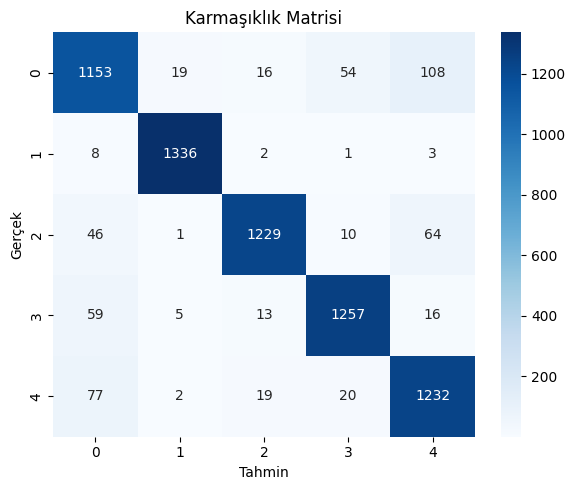

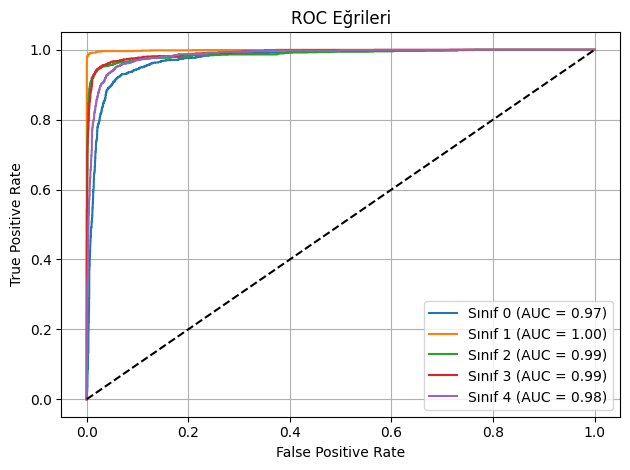

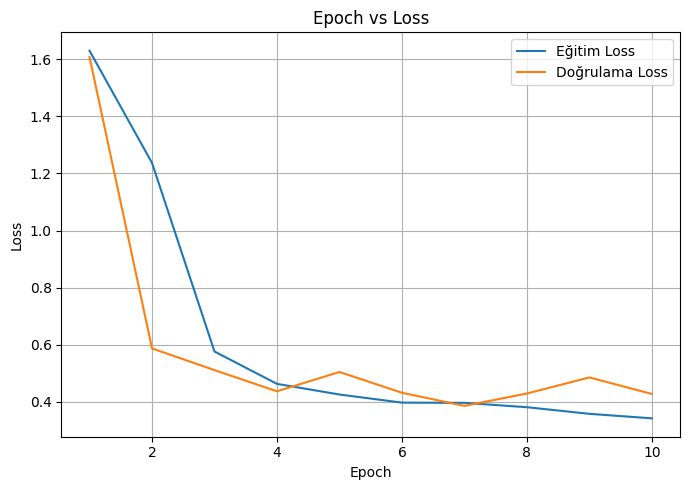

✅ En iyi model ve grafikler Drive'da: /content/drive/MyDrive/best_model_final_roberta_deneme2


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_deneme2"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model
config = AutoConfig.from_pretrained(model_name, num_labels=len(label_encoder.classes_),
                                    hidden_dropout_prob=0.4, attention_probs_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim
start = time.time()
trainer.train()
end = time.time()

print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ En iyi modeli ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Karmaşıklık Matrisi
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'da: {final_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 181


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-763350410.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.618600,1.565176,0.255704,0.648762,0.255704,0.813926,0.167859,0.874701
2,1.114100,0.717243,0.852000,0.856866,0.852000,0.963000,0.852394,0.967279
3,0.711300,0.671563,0.903111,0.903137,0.903111,0.975778,0.903039,0.984516
4,0.639900,0.664772,0.905037,0.905282,0.905037,0.976259,0.904853,0.984141
5,0.617700,0.645805,0.908593,0.908618,0.908593,0.977148,0.908397,0.986330
6,0.600100,0.631854,0.915556,0.917248,0.915556,0.978889,0.916063,0.987702
7,0.586100,0.619059,0.917481,0.917860,0.917481,0.979370,0.917642,0.988431
8,0.577900,0.629421,0.912593,0.912931,0.912593,0.978148,0.912105,0.988020
9,0.572600,0.613376,0.914667,0.914714,0.914667,0.978667,0.914476,0.989032
10,0.562300,0.608253,0.919704,0.919938,0.919704,0.979926,0.919691,0.990066


⏱️ Eğitim süresi: 2092.78 saniye
📌 Bitirilen epoch: 18.0


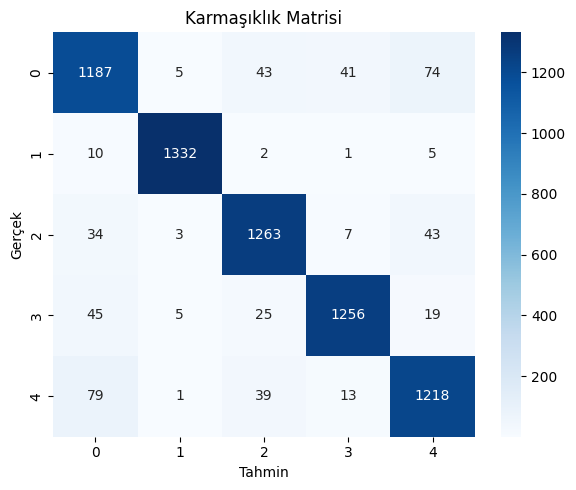

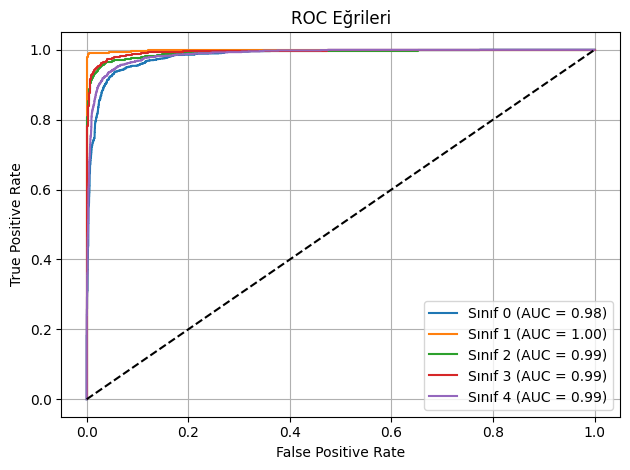

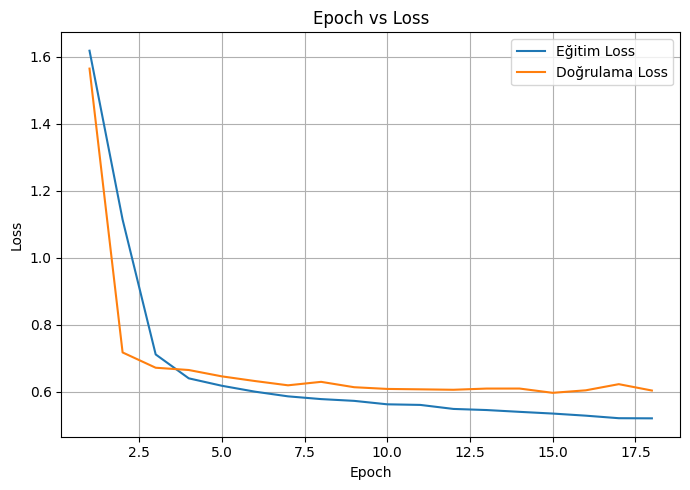

✅ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-471232713.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.614700,1.574222,0.425185,0.483726,0.425185,0.856296,0.328253,0.840103
2,1.210100,0.824936,0.817778,0.824330,0.817778,0.954444,0.818360,0.954586
3,0.788600,0.713832,0.864889,0.867607,0.864889,0.966222,0.865515,0.976146
4,0.706000,0.708414,0.877333,0.877146,0.877333,0.969333,0.876963,0.979594
5,0.673000,0.692080,0.888000,0.891441,0.888000,0.972000,0.889169,0.980096
6,0.656700,0.679266,0.883852,0.887843,0.883852,0.970963,0.884537,0.980621
7,0.642500,0.646210,0.893778,0.896950,0.893778,0.973444,0.894787,0.984040
8,0.634800,0.670466,0.893926,0.895414,0.893926,0.973481,0.894427,0.983486
9,0.620100,0.659352,0.893926,0.895055,0.893926,0.973481,0.894161,0.984300
10,0.613500,0.660365,0.893333,0.894194,0.893333,0.973333,0.893418,0.984288


⏱️ Eğitim süresi: 2142.47 saniye
📌 Bitirilen epoch: 10.0


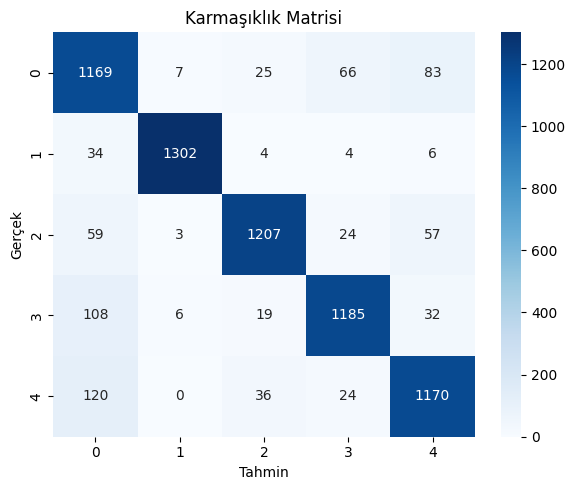

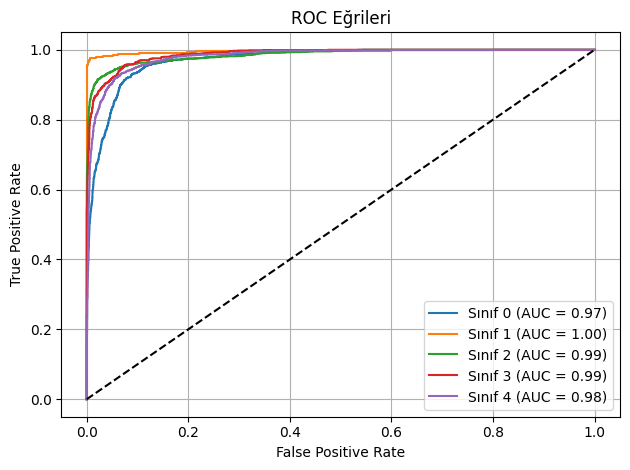

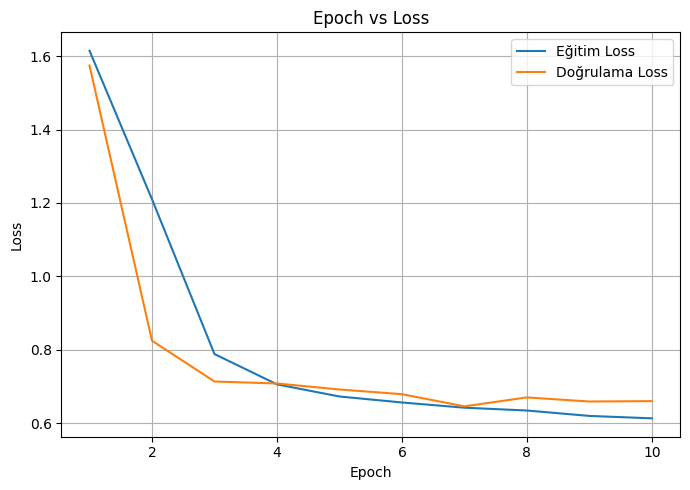

✅ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-2677654299.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.387200,0.757490,0.836593,0.838846,0.836593,0.959148,0.836722,0.957866
2,0.764600,0.703520,0.877481,0.880080,0.877481,0.969370,0.877849,0.979706
3,0.699500,0.759539,0.863259,0.871783,0.863259,0.965815,0.862838,0.979839
4,0.667300,0.752244,0.875704,0.876214,0.875704,0.968926,0.875038,0.979798
5,0.647700,0.730861,0.886963,0.889015,0.886963,0.971741,0.887335,0.978731


⏱️ Eğitim süresi: 1072.87 saniye
📌 Bitirilen epoch: 5.0


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4-1127003266.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.531600,1.066773,0.752148,0.776141,0.752148,0.938037,0.752613,0.922909
2,0.876200,0.768289,0.854519,0.855403,0.854519,0.963630,0.853560,0.969291
3,0.718500,0.711004,0.880000,0.883318,0.880000,0.970000,0.880926,0.978125
4,0.683000,0.724910,0.876444,0.876840,0.876444,0.969111,0.876029,0.979175
5,0.666400,0.739320,0.882519,0.883329,0.882519,0.970630,0.882522,0.978099
6,0.662300,0.672172,0.888741,0.892862,0.888741,0.972185,0.889742,0.981738
7,0.631600,0.670237,0.890963,0.896291,0.890963,0.972741,0.892462,0.981645
8,0.625800,0.664272,0.894222,0.894434,0.894222,0.973556,0.894273,0.983377
9,0.607700,0.685111,0.889778,0.892311,0.889778,0.972444,0.889827,0.982368
10,0.600500,0.670127,0.895556,0.896357,0.895556,0.973889,0.895415,0.981998


⏱️ Eğitim süresi: 2360.94 saniye
📌 Bitirilen epoch: 11.0


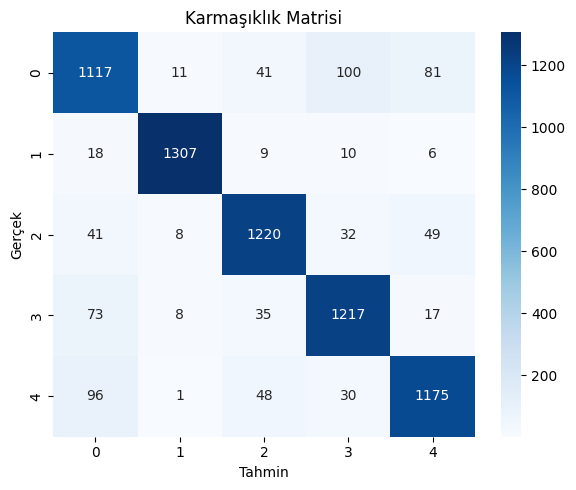

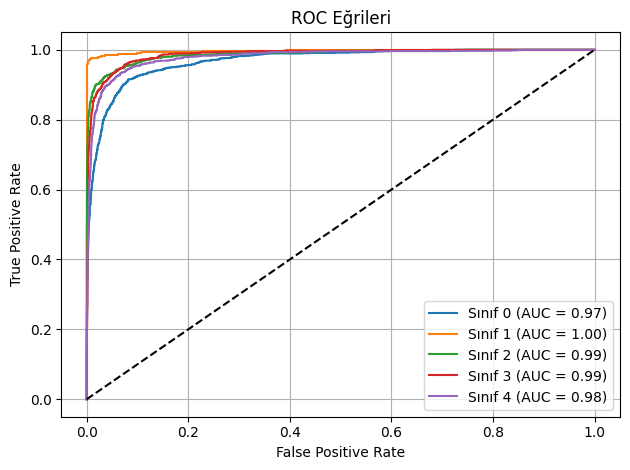

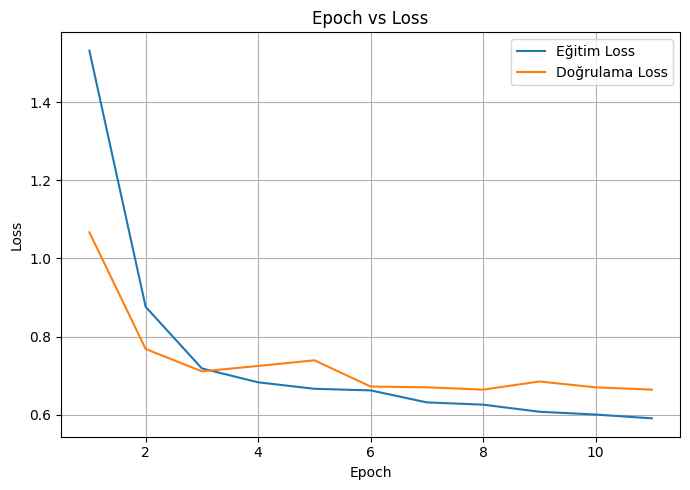

✅ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-540384371.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.615200,1.594969,0.217630,0.501996,0.217630,0.804407,0.100121,0.856744
2,1.198900,0.797074,0.815259,0.825883,0.815259,0.953815,0.816781,0.955402
3,0.784800,0.709553,0.872741,0.873538,0.872741,0.968185,0.872704,0.977012
4,0.704100,0.699244,0.876000,0.877492,0.876000,0.969000,0.876017,0.980026
5,0.676000,0.700156,0.885333,0.889291,0.885333,0.971333,0.886530,0.981918
6,0.657000,0.666564,0.890222,0.892299,0.890222,0.972556,0.890769,0.983026
7,0.633000,0.649139,0.892000,0.896779,0.892000,0.973000,0.893298,0.982622
8,0.632500,0.656905,0.892741,0.892934,0.892741,0.973185,0.892650,0.983852
9,0.611500,0.670529,0.893333,0.893573,0.893333,0.973333,0.893410,0.984692
10,0.607400,0.664745,0.892296,0.892659,0.892296,0.973074,0.892270,0.984179


⏱️ Eğitim süresi: 2148.62 saniye
📌 Bitirilen epoch: 10.0


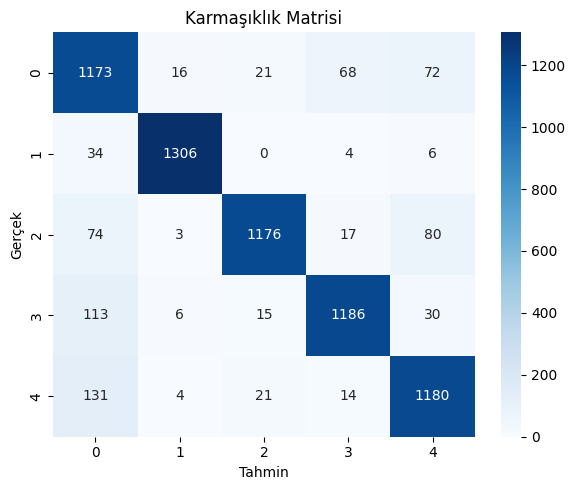

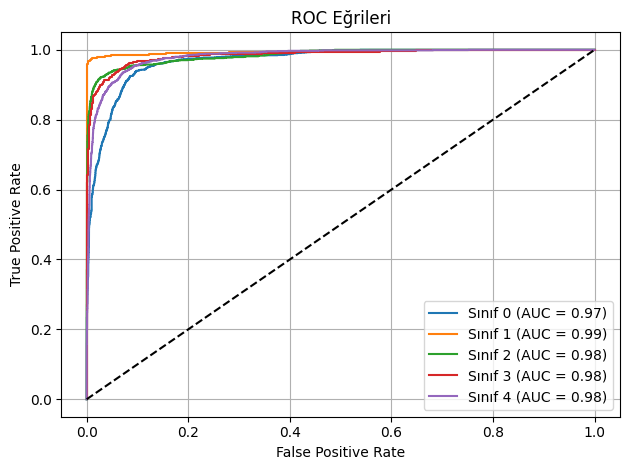

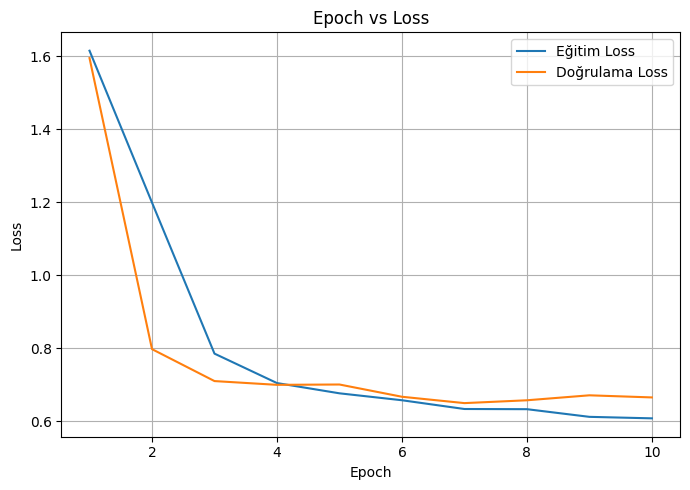

✅ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-536792786.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.618300,1.598864,0.227407,0.545298,0.227407,0.806852,0.115186,0.837680
2,1.193500,0.789766,0.833037,0.836483,0.833037,0.958259,0.833383,0.954068
3,0.781700,0.714703,0.874370,0.875954,0.874370,0.968593,0.874957,0.975288
4,0.702900,0.695560,0.881481,0.881503,0.881481,0.970370,0.881377,0.980576
5,0.673900,0.698444,0.884593,0.886693,0.884593,0.971148,0.885348,0.980825
6,0.663000,0.684424,0.886519,0.889885,0.886519,0.971630,0.887140,0.980663
7,0.643800,0.662648,0.893926,0.896911,0.893926,0.973481,0.894856,0.983841
8,0.633400,0.677022,0.892593,0.893177,0.892593,0.973148,0.892727,0.983786
9,0.621200,0.660715,0.896000,0.897911,0.896000,0.974000,0.896619,0.983546
10,0.616800,0.663230,0.890222,0.890088,0.890222,0.972556,0.889776,0.984278


⏱️ Eğitim süresi: 3075.55 saniye
📌 Bitirilen epoch: 14.0


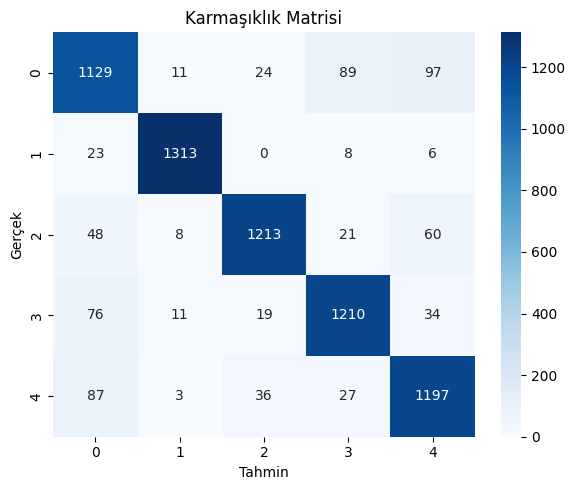

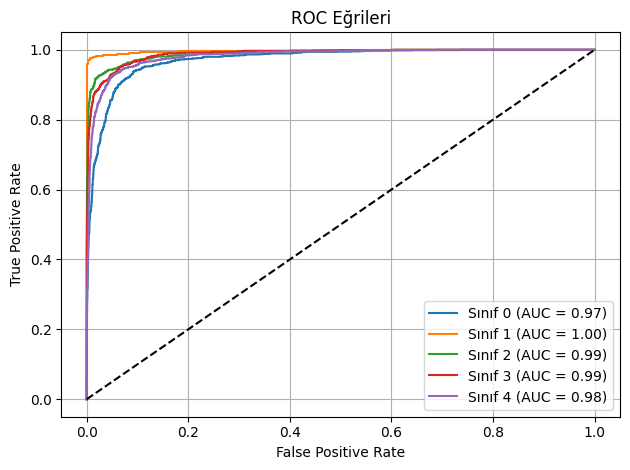

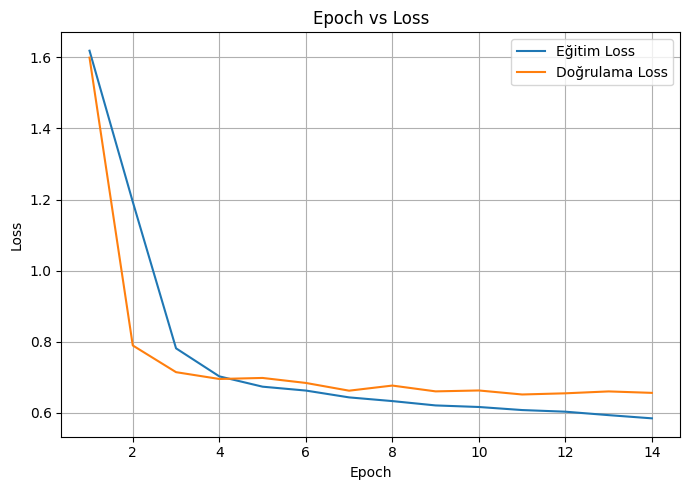

✅ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-1765535583.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.613200,1.545227,0.365333,0.693185,0.365333,0.841333,0.298451,0.870397
2,1.120500,0.770366,0.840000,0.841161,0.840000,0.960000,0.839742,0.959984
3,0.780900,0.746113,0.873333,0.874484,0.873333,0.968333,0.873787,0.976961
4,0.700200,0.724026,0.876593,0.876500,0.876593,0.969148,0.876185,0.980135
5,0.672900,0.681797,0.890519,0.894383,0.890519,0.972630,0.891642,0.980182
6,0.658900,0.686549,0.888741,0.891118,0.888741,0.972185,0.889292,0.981161
7,0.641200,0.652501,0.895111,0.898175,0.895111,0.973778,0.895952,0.983035
8,0.636900,0.665960,0.893481,0.894597,0.893481,0.973370,0.893670,0.983446
9,0.618800,0.670614,0.896296,0.898661,0.896296,0.974074,0.897007,0.982936


KeyboardInterrupt: 

In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.03,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-372414549.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.612600,1.548198,0.361778,0.582783,0.361778,0.840444,0.287758,0.859038
2,1.183700,0.808876,0.821778,0.828448,0.821778,0.955444,0.822356,0.955291
3,0.784700,0.727850,0.866667,0.869556,0.866667,0.966667,0.867082,0.974615
4,0.698900,0.675636,0.884444,0.884551,0.884444,0.971111,0.884490,0.979967
5,0.673300,0.692248,0.888889,0.892281,0.888889,0.972222,0.890039,0.980893
6,0.655800,0.680653,0.887407,0.890305,0.887407,0.971852,0.887971,0.982090
7,0.640000,0.656691,0.896444,0.898790,0.896444,0.974111,0.897198,0.984384
8,0.634800,0.670868,0.892444,0.892923,0.892444,0.973111,0.892592,0.983857
9,0.619400,0.663208,0.895259,0.898387,0.895259,0.973815,0.896148,0.983554
10,0.612700,0.666895,0.895556,0.895961,0.895556,0.973889,0.895521,0.984537


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1-372414549.py", line 147, in <cell line: 0>
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2240, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2555, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3791, in training_step
    self.accelerator.backward(loss, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py", line 2469, in backward
    self.scaler.scale(loss).backward(**kwargs)
  File

TypeError: object of type 'NoneType' has no len()

In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.4
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=3e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.15,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-4013122851.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.621400,1.603489,0.199852,0.039988,0.199852,0.799963,0.066642,0.801996
2,1.326600,0.954685,0.803259,0.814597,0.803259,0.950815,0.804566,0.940894


KeyboardInterrupt: 

In [ ]:
import json
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"

# --- 1. Türkçe Eşanlamlılar Sözlüğü ---
# Bu sözlüğü ihtiyaçlarınıza göre genişletebilirsiniz.
synonym_dict = defaultdict(list)
synonym_dict.update({
    "aşk": ["sevgi", "sevda", "tutku", "aşık", "muhabbet"],
    "yürek": ["kalp", "gönül", "yürek"],
    "gurbet": ["hasret", "özlem", "uzak", "sıla", "dışarısı"],
    "vatan": ["yurt", "memleket", "toprak"],
    "kahraman": ["yiğit", "alp", "cesur", "kahramanlık"],
    "ömür": ["yaşam", "hayat", "ömür"],
    "çile": ["eziyet", "acı", "ızdırap", "dert"],
    "göz": ["nazar", "bakar", "gözler"],
    "yolcu": ["yolcu", "gezgin", "seyyah"],
    "tümsek": ["tepe", "yükseklik"],
    "zulüm": ["acımasızlık", "işkence"],
    "hasret": ["özlem", "gurbet"],
    "dağ": ["cebel", "sıradağ"],
    "acı": ["ızdırap", "çile"],
    "dünya": ["alem", "cihan", "evren"],
    "insan": ["kişi", "birey", "beşer"],
    "dost": ["arkadaş", "yoldaş", "ahbap"],
    "kader": ["yazgı", "talih"],
    "sessiz": ["sakin", "dingin", "suspus"],
    "ırmak": ["nehir", "akarsu"],
    "deniz": ["derya", "umman"],
    "gül": ["çiçek", "gonca"],
    "bülbül": ["şakrak", "kanarya"],
    "hürriyet": ["özgürlük", "bağımsızlık"],
    "savaş": ["harp", "muharebe", "çatışma"],
    "zafer": ["galibiyet", "yenme"],
    "şair": ["ozan", "dizeler", "şiirci"],
    "şiir": ["koşuk", "manzume"],
    "mübarek": ["kutlu", "uğurlu"],
    "toprak": ["arazi", "yer"],
    "kan": ["dem", "doku"],
    "can": ["ruh", "hayat"],
    "yıl": ["sene"],
    "gün": ["gündüz"],
    "gece": ["leyl"],
    "ışık": ["nur", "aydınlık"],
    "zaman": ["vakit", "çağ", "devir"],
    "kalp": ["yürek", "gönül", "çehre"],
    "umut": ["beklenti", "hayal"],
    "düşman": ["hasım", "rakip"],
    "cennet": ["uçmak", "adan"],
    "cehennem": ["tamuy"],
    "su": ["ab"],
    "ateş": ["od", "nar"],
    "güneş": ["gün", "hürşit"],
    "ay": ["kamer"],
    "yıldız": ["ahter"],
    "rüzgar": ["yel", "bad"],
    "ağaç": ["dar", "nebat"],
    "yaprak": ["varak"],
    "neşe": ["sevinç", "coşku"],
    "keder": ["üzüntü", "gam"],
    "hayal": ["düş", "hülya"],
    "bilgi": ["ilim", "malumat"],
    "okul": ["mektep"],
    "öğretmen": ["hoca", "muallim"],
    "öğrenci": ["talebe", "şakirt"],
    "ders": ["konu", "etüt"],
    "kitap": ["eser", "yazma"],
    "yazmak": ["kaleme almak", "tashih etmek"],
    "okumak": ["mütalaa etmek"],
    "konuşmak": ["söylemek", "demek"],
    "dinlemek": ["kulak vermek"],
    "görmek": ["bakmak", "seyretmek"],
    "duymak": ["işitmek"],
    "yemek": ["aş", "gıda"],
    "içmek": ["nûş etmek"],
    "uyumak": ["horlamak", "uykuya dalmak"],
    "uyanmak": ["gözünü açmak"],
    "gitmek": ["varmak", "seyahat etmek"],
    "gelmek": ["ulaşmak", "teşrif etmek"],
    "koşmak": ["sprint atmak", "hızla gitmek"],
    "yürümek": ["adımlamak", "gezmek"],
    "oturmak": ["ikamet etmek", "çökmek"],
    "kalkmak": ["ayağa kalkmak"],
    "sevmek": ["aşık olmak", "beğenmek"],
    "nefret": ["kin", "düşmanlık"],
    "mutlu": ["mesut", "şen"],
    "üzgün": ["kederli", "mahzun"],
    "büyük": ["iri", "ulu"],
    "küçük": ["ufak", "minik"],
    "iyi": ["güzel", "hoş"],
    "kötü": ["fena", "çirkin"],
    "doğru": ["hakikat", "gerçek"],
    "yanlış": ["hatalı", "eksik"],
    "sıcak": ["hararetli"],
    "soğuk": ["buz gibi", "serin"],
    "hızlı": ["çabuk", "süratli"],
    "yavaş": ["ağır", "sürüncemeli"],
    "açık": ["vazıh", "aydınlık"],
    "kapalı": ["örtülü", "mahcup"],
    "yeni": ["cedit", "taze"],
    "eski": ["köhne", "antik"],
    "bol": ["çok", "fazla"],
    "az": ["kıt", "eksik"],
    "temiz": ["pak", "saf"],
    "kirli": ["pis", "pasaklı"],
    "zor": ["güç", "çetin"],
    "kolay": ["basit", "rahat"],
    "yüksek": ["ali", "yüce"],
    "alçak": ["pes", "bayağı"],
    "güzel": ["cemil", "hüsnü"],
    "çirkin": ["nahoş", "mekruh"],
    "sessiz": ["sakin", "dingin"],
    "gürültülü": ["patırtılı", "cızırtılı"],
    "aydınlık": ["ışıklı", "parlak"],
    "karanlık": ["zulmetli", "siyah"]
})


# --- 2. Veri Artırma Fonksiyonları (EDA) ---

def get_synonyms(word, synonym_dict):
    """Bir kelimenin eşanlamlılarını döndürür."""
    return synonym_dict.get(word, [word])

def synonym_replacement(words, n):
    """
    Kelimelerin n kadarını eşanlamlılarıyla değiştirir.
    words: Liste halinde kelimeler.
    n: Kaç kelimenin değiştirileceği.
    """
    new_words = list(words)
    random_word_list = list(set([word for word in words if get_synonyms(word, synonym_dict)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word, synonym_dict)
        if len(synonyms) > 1:
            synonym = random.choice(list(set(synonyms) - set([random_word])))
            # Kelimenin birden fazla geçtiği durumlarda tüm örneklerini değiştirmek yerine ilkini değiştiririz.
            # Daha sofistike bir yaklaşım için tüm geçişleri bulup değiştirmek gerekebilir.
            if random_word in new_words:
                idx = new_words.index(random_word)
                new_words[idx] = synonym
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(words, n):
    """
    Rastgele seçilen n tane kelimenin eşanlamlılarını rastgele yerlere ekler.
    """
    new_words = list(words)
    for _ in range(n):
        word_to_insert = random.choice(words)
        synonyms = get_synonyms(word_to_insert, synonym_dict)
        if synonyms: # Eşanlamlı varsa
            new_word = random.choice(synonyms)
            new_words.insert(random.randint(0, len(new_words)), new_word)
    return ' '.join(new_words)

def random_swap(words, n):
    """
    n kez rastgele iki kelimenin yerini değiştirir.
    """
    new_words = list(words)
    if len(new_words) < 2: # Takas için en az 2 kelime olmalı
        return ' '.join(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return ' '.join(new_words)

def random_deletion(words, p):
    """
    Kelimelerin p olasılıkla silinmesini sağlar.
    """
    if len(words) == 1:
        return ' '.join(words)
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words) # Tüm kelimeler silinirse, orijinalden rastgele birini bırak
    return ' '.join(new_words)

def augment_text(text, num_aug=1):
    """
    Bir metni çeşitli EDA teknikleriyle artırır.
    num_aug: Her orijinal metinden kaç artırılmış örnek oluşturulacağı.
    """
    words = text.split()
    augmented_texts = []
    if not words: # Boş metinler için koruma
        return [""] * num_aug

    for _ in range(num_aug):
        aug_text_list = list(words) # Kopyasını al

        choice = random.randint(0, 3)
        if choice == 0: # Eşanlamlı kelime değiştirme
            aug_text_list = synonym_replacement(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 1: # Rastgele ekleme
            aug_text_list = random_insertion(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 2: # Rastgele takas
            aug_text_list = random_swap(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 3: # Rastgele silme
            aug_text_list = random_deletion(aug_text_list, 0.1)

        augmented_texts.append(aug_text_list) # Zaten string olarak döndürüyor

    return augmented_texts


# --- 3. Veri Okuma ve Birleştirme ---

print("Veri setleri okunuyor...")
try:
    with open(train_path, 'r', encoding='utf-8') as f:
        train_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
    with open(val_path, 'r', encoding='utf-8') as f:
        val_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
except FileNotFoundError:
    print(f"Hata: Dosya bulunamadı. Lütfen '{train_path}' ve '{val_path}' yollarını kontrol edin.")
    # Colab kullanıyorsanız, drive'ı bağladığınızdan emin olun:
    # from google.colab import drive
    # drive.mount('/content/drive')
    exit()
except json.JSONDecodeError as e:
    print(f"JSON Decode Hatası: {e}")
    print("Lütfen JSON dosyanızın geçerli bir formatta olduğundan emin olun.")
    exit()


df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

# Toplam veri setini oluşturalım, böylece yeniden bölebiliriz.
# Eğer test setiniz tamamen ayrı ve hiç değişmeyecekse, bu birleştirmeyi yapmayıp sadece train_data'yı artırıp sonra bölmeniz gerekir.
# Ancak genel yaklaşım, train ve val'ı birleştirip artırma yapıp sonra yeniden bölmektir.
df_combined = pd.concat([df_train, df_val], ignore_index=True)
print(f"Toplam orijinal veri boyutu: {len(df_combined)} örnek.")

# --- 4. Veri Artırma Uygulaması ---

print("Eğitim verisi artırılıyor...")
augmented_records = []
# Her orijinal şiir için 1 artırılmış örnek oluşturacağız. (num_aug=1)
# Eğer daha fazla artırma istiyorsanız, num_aug değerini artırabilirsiniz (örn. num_aug=2).
# Bu durumda veri setiniz (orijinal + num_aug * orijinal) boyutunda olur.
# Mevcut haliyle, her şiirden 1 artırılmış kopya oluşturulup orijinalle birleştirilecektir.
for index, row in df_combined.iterrows():
    original_siir = row['islenmis_siir']
    augmented_siirs = augment_text(original_siir, num_aug=1) # Her orijinal için 1 yeni örnek
    for aug_siir in augmented_siirs:
        augmented_records.append({
            "baslik": row["baslik"],
            "siir": row["siir"],
            "konu": row["konu"],
            "islenmis_siir": aug_siir
        })

df_augmented = pd.DataFrame(augmented_records)

# Orijinal veriyi ve artırılmış veriyi birleştir
df_final_augmented = pd.concat([df_combined, df_augmented], ignore_index=True)
print(f"Veri artırma sonrası toplam veri boyutu: {len(df_final_augmented)} örnek.")

# --- 5. Veri Bölme ve Kaydetme ---

output_dir = "/content/drive/MyDrive/"

def save_dataframes_to_jsonl(df_train_part, df_val_part, train_filename, val_filename):
    """DataFrame'leri JSONL formatında kaydeder."""
    train_output_path = f"{output_dir}{train_filename}"
    val_output_path = f"{output_dir}{val_filename}"

    # Save as JSON (list of objects) instead of JSONL (line-delimited JSON)
    with open(train_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_train_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    with open(val_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_val_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    print(f"Dosyalar kaydedildi: {train_output_path} ve {val_output_path}")


# 5.1. %70 Eğitim / %30 Doğrulama Ayrımı
print("\n%70 Eğitim / %30 Doğrulama ayrımı yapılıyor...")
train_70, val_30 = train_test_split(
    df_final_augmented,
    test_size=0.3,
    stratify=df_final_augmented['konu'], # Konu dağılımını koru
    random_state=42
)
print(f"70/30 Eğitim Boyutu: {len(train_70)}, Doğrulama Boyutu: {len(val_30)}")
save_dataframes_to_jsonl(train_70, val_30, "augmented_train_70_30.json", "augmented_val_70_30.json")

# 5.2. %80 Eğitim / %20 Doğrulama Ayrımı
print("\n%80 Eğitim / %20 Doğrulama ayrımı yapılıyor...")
train_80, val_20 = train_test_split(
    df_final_augmented,
    test_size=0.2,
    stratify=df_final_augmented['konu'], # Konu dağılımını koru
    random_state=42
)
print(f"80/20 Eğitim Boyutu: {len(train_80)}, Doğrulama Boyutu: {len(val_20)}")
save_dataframes_to_jsonl(train_80, val_20, "augmented_train_80_20.json", "augmented_val_80_20.json")

print("\nVeri artırma ve bölme işlemleri tamamlandı.")
print("Şimdi bu yeni JSON dosyalarını (örneğin augmented_train_80_20.json) eğitim kodunuzda kullanabilirsiniz.")

Veri setleri okunuyor...
Toplam orijinal veri boyutu: 22494 örnek.
Eğitim verisi artırılıyor...
Veri artırma sonrası toplam veri boyutu: 44988 örnek.

%70 Eğitim / %30 Doğrulama ayrımı yapılıyor...
70/30 Eğitim Boyutu: 31491, Doğrulama Boyutu: 13497
Dosyalar kaydedildi: /content/drive/MyDrive/augmented_train_70_30.json ve /content/drive/MyDrive/augmented_val_70_30.json

%80 Eğitim / %20 Doğrulama ayrımı yapılıyor...
80/20 Eğitim Boyutu: 35990, Doğrulama Boyutu: 8998
Dosyalar kaydedildi: /content/drive/MyDrive/augmented_train_80_20.json ve /content/drive/MyDrive/augmented_val_80_20.json

Veri artırma ve bölme işlemleri tamamlandı.
Şimdi bu yeni JSON dosyalarını (örneğin augmented_train_80_20.json) eğitim kodunuzda kullanabilirsiniz.


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 🔹 Eğitim ve doğrulama verilerini DataFrame'e çevir
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# 🔹 Eğitim/Doğrulama oranı
train_len = len(train_df)
val_len = len(val_df)
total_len = train_len + val_len
train_ratio = train_len / total_len
val_ratio = val_len / total_len

print(f"🔹 Eğitim oranı: {train_ratio:.2%}")
print(f"🔹 Doğrulama oranı: {val_ratio:.2%}")

# 🔹 Label sayımı (her etikette kaç tane örnek var)
print("\n📊 Etiket Dağılımı (Eğitim Verisi):")
print(train_df['konu'].value_counts())

print("\n📊 Etiket Dağılımı (Doğrulama Verisi):")
print(val_df['konu'].value_counts())

🔹 Eğitim oranı: 69.99%
🔹 Doğrulama oranı: 30.01%

📊 Etiket Dağılımı (Eğitim Verisi):
konu
gurbet         3149
tasavvuf       3149
pastoral       3149
kahramanlık    3149
aşk            3148
Name: count, dtype: int64

📊 Etiket Dağılımı (Doğrulama Verisi):
konu
gurbet         1350
aşk            1350
kahramanlık    1350
pastoral       1350
tasavvuf       1350
Name: count, dtype: int64


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Mounted at /content/drive
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 163


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-555040282.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.513800,0.982598,0.761391,0.790342,0.761407,0.940349,0.764460,0.924525
2,0.847900,0.696606,0.876750,0.880607,0.876750,0.969188,0.877927,0.975072
3,0.696700,0.672622,0.888975,0.889463,0.888968,0.972244,0.888944,0.983158
4,0.653300,0.643204,0.903534,0.906604,0.903532,0.975884,0.904330,0.986036
5,0.629900,0.630906,0.904312,0.906526,0.904307,0.976078,0.904385,0.987277
6,0.613600,0.630203,0.906424,0.907236,0.906421,0.976606,0.906593,0.986874
7,0.601500,0.609056,0.914425,0.915918,0.914420,0.978607,0.914914,0.989053
8,0.591800,0.608089,0.916759,0.919927,0.916759,0.979190,0.917583,0.989349
9,0.580600,0.604195,0.919649,0.920565,0.919644,0.979912,0.919856,0.989690
10,0.572700,0.598605,0.923316,0.923988,0.923313,0.980829,0.923558,0.990170


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.513800,0.982598,0.761391,0.790342,0.761407,0.940349,0.764460,0.924525
2,0.847900,0.696606,0.876750,0.880607,0.876750,0.969188,0.877927,0.975072
3,0.696700,0.672622,0.888975,0.889463,0.888968,0.972244,0.888944,0.983158
4,0.653300,0.643204,0.903534,0.906604,0.903532,0.975884,0.904330,0.986036
5,0.629900,0.630906,0.904312,0.906526,0.904307,0.976078,0.904385,0.987277
6,0.613600,0.630203,0.906424,0.907236,0.906421,0.976606,0.906593,0.986874
7,0.601500,0.609056,0.914425,0.915918,0.914420,0.978607,0.914914,0.989053
8,0.591800,0.608089,0.916759,0.919927,0.916759,0.979190,0.917583,0.989349
9,0.580600,0.604195,0.919649,0.920565,0.919644,0.979912,0.919856,0.989690
10,0.572700,0.598605,0.923316,0.923988,0.923313,0.980829,0.923558,0.990170


⏱️ Eğitim süresi: 7933.70 saniye
📌 Bitirilen epoch: 17.0


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda
📏 Max Length: 163


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-62672579.py:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.614200,1.587961,0.356413,0.183848,0.356333,0.839094,0.204686,0.849031
2,1.287300,0.952270,0.782174,0.800802,0.782181,0.945544,0.782772,0.930359
3,0.850000,0.732294,0.862747,0.863459,0.862742,0.965687,0.862950,0.971884
4,0.727900,0.697545,0.881863,0.884342,0.881861,0.970466,0.882673,0.980006
5,0.681500,0.668386,0.891198,0.892972,0.891192,0.972800,0.891614,0.983326
6,0.659400,0.654350,0.899311,0.901749,0.899306,0.974828,0.900022,0.985319
7,0.640100,0.653097,0.899533,0.902179,0.899525,0.974883,0.900083,0.986370
8,0.625400,0.632596,0.907980,0.911157,0.907979,0.976995,0.908859,0.987283
9,0.616500,0.638211,0.906313,0.908198,0.906304,0.976578,0.906451,0.987981
10,0.604600,0.619753,0.911980,0.912744,0.911975,0.977995,0.912212,0.988378


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.614200,1.587961,0.356413,0.183848,0.356333,0.839094,0.204686,0.849031
2,1.287300,0.952270,0.782174,0.800802,0.782181,0.945544,0.782772,0.930359
3,0.850000,0.732294,0.862747,0.863459,0.862742,0.965687,0.862950,0.971884
4,0.727900,0.697545,0.881863,0.884342,0.881861,0.970466,0.882673,0.980006
5,0.681500,0.668386,0.891198,0.892972,0.891192,0.972800,0.891614,0.983326
6,0.659400,0.654350,0.899311,0.901749,0.899306,0.974828,0.900022,0.985319
7,0.640100,0.653097,0.899533,0.902179,0.899525,0.974883,0.900083,0.986370
8,0.625400,0.632596,0.907980,0.911157,0.907979,0.976995,0.908859,0.987283
9,0.616500,0.638211,0.906313,0.908198,0.906304,0.976578,0.906451,0.987981
10,0.604600,0.619753,0.911980,0.912744,0.911975,0.977995,0.912212,0.988378


⏱️ Eğitim süresi: 13133.83 saniye
📌 Bitirilen epoch: 21.0


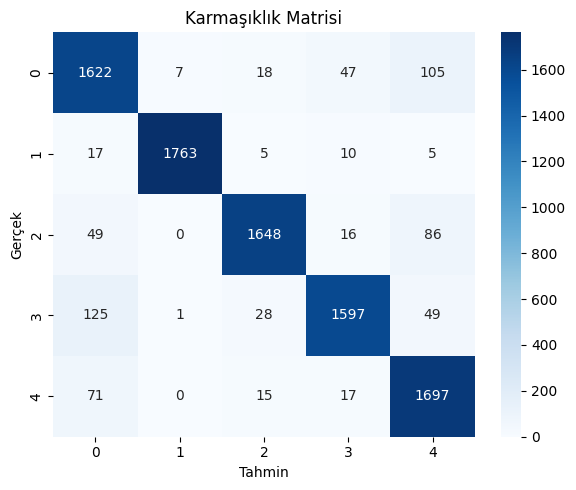

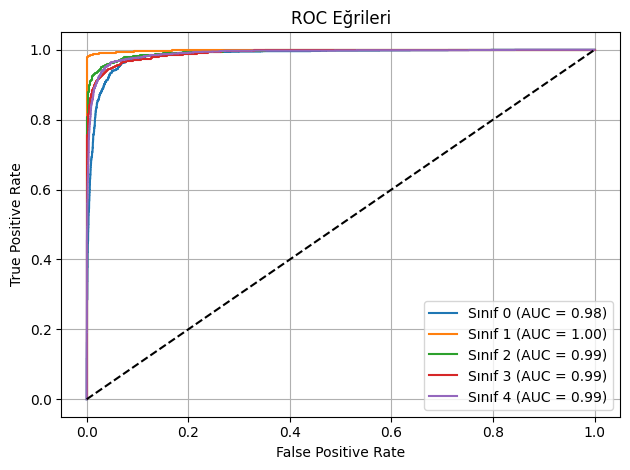

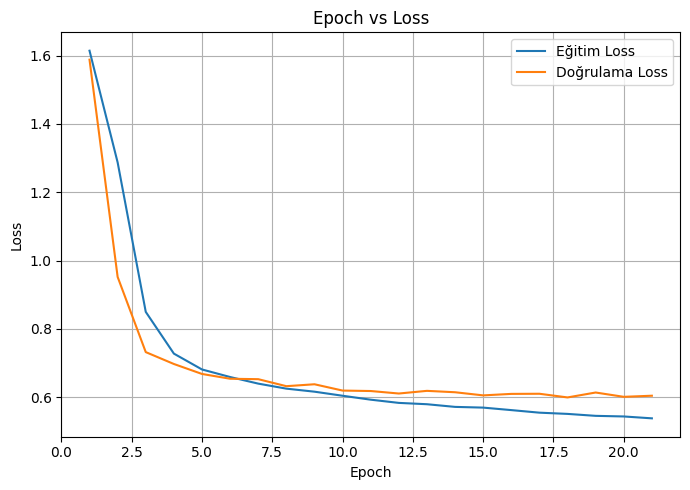

✅ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt


In [ ]:
# ✅ Ortamı ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ✅ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Maksimum uzunluğu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"📏 Max Length: {max_len}")

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ✅ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=3e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
end = time.time()
print(f"⏱️ Eğitim süresi: {end - start:.2f} saniye")
print(f"📌 Bitirilen epoch: {trainer.state.epoch:.1f}")

# ✅ Model ve label encoder'ı Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ✅ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ✅ ROC Eğrileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ✅ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eğitim Loss")
plt.plot(epochs, eval_losses, label="Doğrulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"✅ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")